In [57]:
import pandas as pd 
import numpy as np 
import sklearn.model_selection as sk
from sklearn.preprocessing import LabelEncoder

In [58]:
TRAIN_BUS_CSV_PATH = "data/train_bus_schedule.csv"
X_PASSENGER = "data/X_passengers_up.csv"
X_TRIP = "data/X_trip_duration.csv"
ENCODER = "windows-1255"
RANDOM_STATE = 42

In [59]:
train_bus = pd.read_csv(TRAIN_BUS_CSV_PATH, encoding=ENCODER)
x_passenger = pd.read_csv(X_PASSENGER, encoding=ENCODER)
x_trip_duration = pd.read_csv(X_TRIP, encoding=ENCODER)

data splitting

In [60]:
y = train_bus["passengers_up"]

In [61]:
len(x_passenger)

48303

In [139]:

sample_size = 0.05  # 5% of the data
baseline = train_bus.sample(frac=sample_size, random_state=RANDOM_STATE)
remaining_data = train_bus.drop(baseline.index)

base line - linearregression

In [140]:
x_base_line = baseline[x_passenger.columns]
y_base_line = baseline["passengers_up"]

pre process data

In [141]:
import pandas as pd


columns_with_nan = [col for col in x_base_line.columns if x_base_line[col].isna().any()]
print(columns_with_nan)


['door_closing_time']


In [142]:


# Assuming x_base_line is your DataFrame
# Convert relevant columns to datetime if needed
x_base_line['door_closing_time'] = pd.to_datetime(x_base_line['door_closing_time'])
x_base_line['arrival_time'] = pd.to_datetime(x_base_line['arrival_time'])


# If you need to convert the result to seconds or another format, you can further process it


/var/folders/24/vfbkhj7j0t142rz214mskjkr0000gn/T/ipykernel_24514/385723958.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_base_line['door_closing_time'] = pd.to_datetime(x_base_line['door_closing_time'])
/var/folders/24/vfbkhj7j0t142rz214mskjkr0000gn/T/ipykernel_24514/385723958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_base_line['door_closing_time'] = pd.to_datetime(x_base_line['door_closing_time'])
/var/folders/24/vfbkhj7j0t142rz214mskjkr0000gn/T/ipykernel_24514/385723958.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To 

In [143]:
x_base_line["door_close_delta"] = None
x_base_line.loc[x_base_line["door_closing_time"].notna(),['door_close_delta']] =(x_base_line.loc[x_base_line["door_closing_time"].notna(),'door_closing_time'] - x_base_line.loc[x_base_line["door_closing_time"].notna(),'arrival_time']).dt.total_seconds()



In [144]:
door_delta_mean = x_base_line["door_close_delta"].mean()
x_base_line["door_close_delta"] = x_base_line["door_close_delta"].fillna(door_delta_mean)

/var/folders/24/vfbkhj7j0t142rz214mskjkr0000gn/T/ipykernel_24514/2048116025.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_base_line["door_close_delta"] = x_base_line["door_close_delta"].fillna(door_delta_mean)


In [145]:
x_base_line['arrival_time'].dt.hour.describe(percentiles=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))

count    11306.000000
mean        13.155227
std          5.059352
min          0.000000
10%          6.000000
20%          8.000000
30%         10.000000
40%         11.000000
50%         13.000000
60%         15.000000
70%         16.000000
80%         18.000000
90%         20.000000
max         23.000000
Name: arrival_time, dtype: float64

In [120]:


x_base_line['arrival_time'] = pd.to_datetime(x_base_line['arrival_time'])
arrival_hours = x_base_line['arrival_time'].dt.hour
percentiles = arrival_hours.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
percentile_values = percentiles.loc[['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%']].values
labels = []
previous = 0
for value in percentile_values:
    labels.append(f'{int(previous)}-{int(value)}')
    previous = value
labels.append(f'{int(percentile_values[-1])}-24')
x_base_line['arrival_time_label'] = pd.cut(arrival_hours, 
                                           bins=[0] + list(percentile_values) + [24], 
                                           labels=labels, 
                                           include_lowest=True)



In [147]:

# Convert arrival_time to datetime
x_base_line['arrival_time'] = pd.to_datetime(x_base_line['arrival_time'])

# Extract the hour from 'arrival_time' for percentile calculation
arrival_hours = x_base_line['arrival_time'].dt.hour

# Calculate the percentiles
percentiles = arrival_hours.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
percentile_values = percentiles.loc[['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%']].values

# Create labels for the bins based on lower bounds
labels = [f'{int(value)}' for value in percentile_values]
labels.insert(0, '0')

# Use pd.cut to categorize arrival hours into bins based on the calculated percentiles
x_base_line['arrival_time_label'] = pd.cut(arrival_hours, 
                                           bins=[0] + list(percentile_values) + [24], 
                                           labels=labels, 
                                           include_lowest=True)

# Now x_base_line['arrival_time_label'] contains the categorized labels based on lower bounds
print(x_base_line[['arrival_time', 'arrival_time_label']])


              arrival_time arrival_time_label
23389  2024-07-03 14:58:00                 13
216720 2024-07-03 20:08:00                 18
39878  2024-07-03 15:01:00                 13
73804  2024-07-03 18:13:00                 16
47587  2024-07-03 15:16:45                 13
...                    ...                ...
46303  2024-07-03 19:47:09                 18
222488 2024-07-03 12:05:11                 11
39841  2024-07-03 13:15:00                 11
109055 2024-07-03 11:31:00                 10
191377 2024-07-03 15:35:00                 13

[11306 rows x 2 columns]


In [166]:
# Label Encoding
label_encoder = LabelEncoder()
x_base_line['part_encoded'] = label_encoder.fit_transform(x_base_line['part'])
x_base_line['alternative_encoded'] = label_encoder.fit_transform(x_base_line['alternative'])

In [167]:
del x_base_line["arrival_time"]
del x_base_line["door_closing_time"]
del x_base_line["cluster"]
del x_base_line["station_name"]
del x_base_line["part"]
del x_base_line["trip_id_unique"]
del x_base_line["trip_id_unique_station"]
del x_base_line["alternative"]

spliting

In [168]:
X_train,X_test,y_train,y_test = sk.train_test_split(x_base_line,y_base_line,test_size=0.25,random_state=RANDOM_STATE)

training

In [169]:
for col in X_train.columns:
    try:
        X_train[col].astype(float)
    except Exception as err:
        print(col)
        print (err)

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [171]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [173]:
mse

2.5900408774298453

In [174]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
model_dt.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = model_dt.predict(X_test)

# Calculate performance metrics
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print('Decision Tree Regression')
print(f'Mean Squared Error: {mse_dt}')
print(f'R^2 Score: {r2_dt}')
print(f'Predictions: {y_pred_dt}')
print(f'Actual values: {y_test.values}')


Decision Tree Regression
Mean Squared Error: 4.139016625397948
R^2 Score: -0.11171106310688539
Predictions: [3. 0. 0. ... 0. 0. 1.]
Actual values: [4 0 2 ... 4 0 1]


In [175]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

Degree 1: MSE = 2.5900408774298316
Degree 2: MSE = 2.5604501302657274
Degree 3: MSE = 63.19311779872775


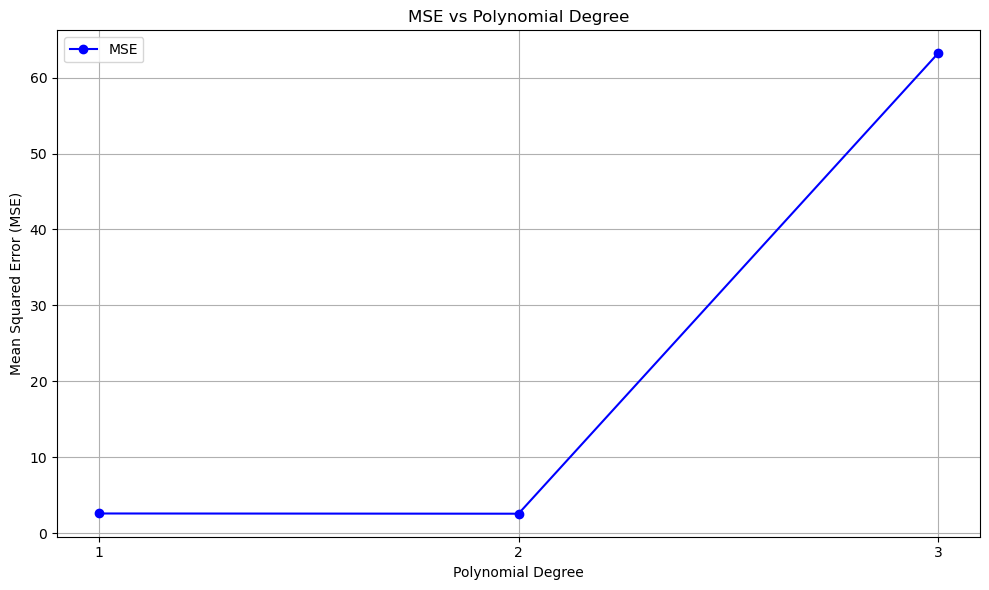

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Sample DataFrames (replace these with your actual DataFrames)
# Assuming X_train, X_test, y_train, y_test are already defined

# Range of polynomial degrees to test
degrees = range(1, 4)  # Testing degrees 1 to 5

# Initialize lists to store MSE values for each degree
mse_values = []

# Iterate over each degree
for degree in degrees:
    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Initialize and train the Polynomial Regression model
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)
    
    # Predict on the test set
    y_pred_poly = model_poly.predict(X_test_poly)
    
    # Calculate MSE
    mse_poly = mean_squared_error(y_test, y_pred_poly)
    
    # Append MSE to list
    mse_values.append(mse_poly)
    
    # Print MSE for each degree
